In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from hamilton import driver
import torch
from tensordict import TensorDict
import tqdm

from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
d = driver.Builder().with_modules(base, shared).build()

In [4]:
inputs = {"sequence_length": 1000,
            "n_sequence": 10000,
            "context_size": 200,
            "state_dimensions": None,
            "batch_size": 32,
            "device": device,
            "seed":[0, 42],
            "state_control": "periodic",
            "measurement_shift": 0
        }

outputs = d.execute(["toy1d_data", "toy1d_dataloaders"], inputs=inputs)

In [5]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

In [6]:
names = [

    "Break1_M0-100_FF_H0x_SS128_Alibi_SCheckSensorial_Head4", 
    "Break1_M0-100_FF_H0x_SS128_Alibi_SCheckSensorial_Head4_STR5-MD", 
]

long = False
long2 = False

if long2:
    n_epoch = 15
    experiment_path = "toy1d_memory_long3"
elif long:
    n_epoch = 20
    experiment_path = "toy1d_memory_long2"
else:
    n_epoch = 5
    experiment_path = "toy1d_memory"

models = {}
for name in names:
    try:
        models[name] = torch.load(os.path.join(experiment_path, name, "run_0","toy1d_model.pt"))
    except:
        pass


for name in models:
    models[name].eval()
    models[name].to(device)
    
    if not hasattr(models[name], "_state_dropout"):
        models[name]._state_dropout = None

torch.set_grad_enabled(False)

len(models)

C:\Users\eltsu\AppData\Local\Temp\ipykernel_7492\107846836.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models[name] = torch.load(os.path.join(experiment_path, name,

2

In [7]:
inputs: torch.Tensor = item["inputs"].to(device)
targets: torch.Tensor = item["targets"]["state_decoded"].to(
    device)

if "state_decoded" in inputs:
    batch_size = inputs["state_decoded"].shape[0]
    seq_len = inputs["state_decoded"].shape[1]

state = {}

for model_name in models:
    state_size = models[model_name]._state_size
    state[model_name] = torch.rand((batch_size, seq_len, state_size), device=device)
    state[model_name] = (2*state[model_name])-1
    state[model_name][:, 0, :] = 0

sensorial_masks = None

for i in range(seq_len):
    logits = {}
    for name in models:
        
        if name == "NoDiscover_M0-90":
            state_decoded = inputs["state_decoded"]
        else:
            state_decoded = None

        logits[name] = models[name](
            state=state[name], 
            state_decoded=state_decoded,
            sensorial_data=inputs, sensorial_masks=sensorial_masks)

        if i != seq_len-1:
            state[name][:, i+1] = logits[name]["state"][:, i]


logits_full = {name:logits[name].cpu() for name in logits}

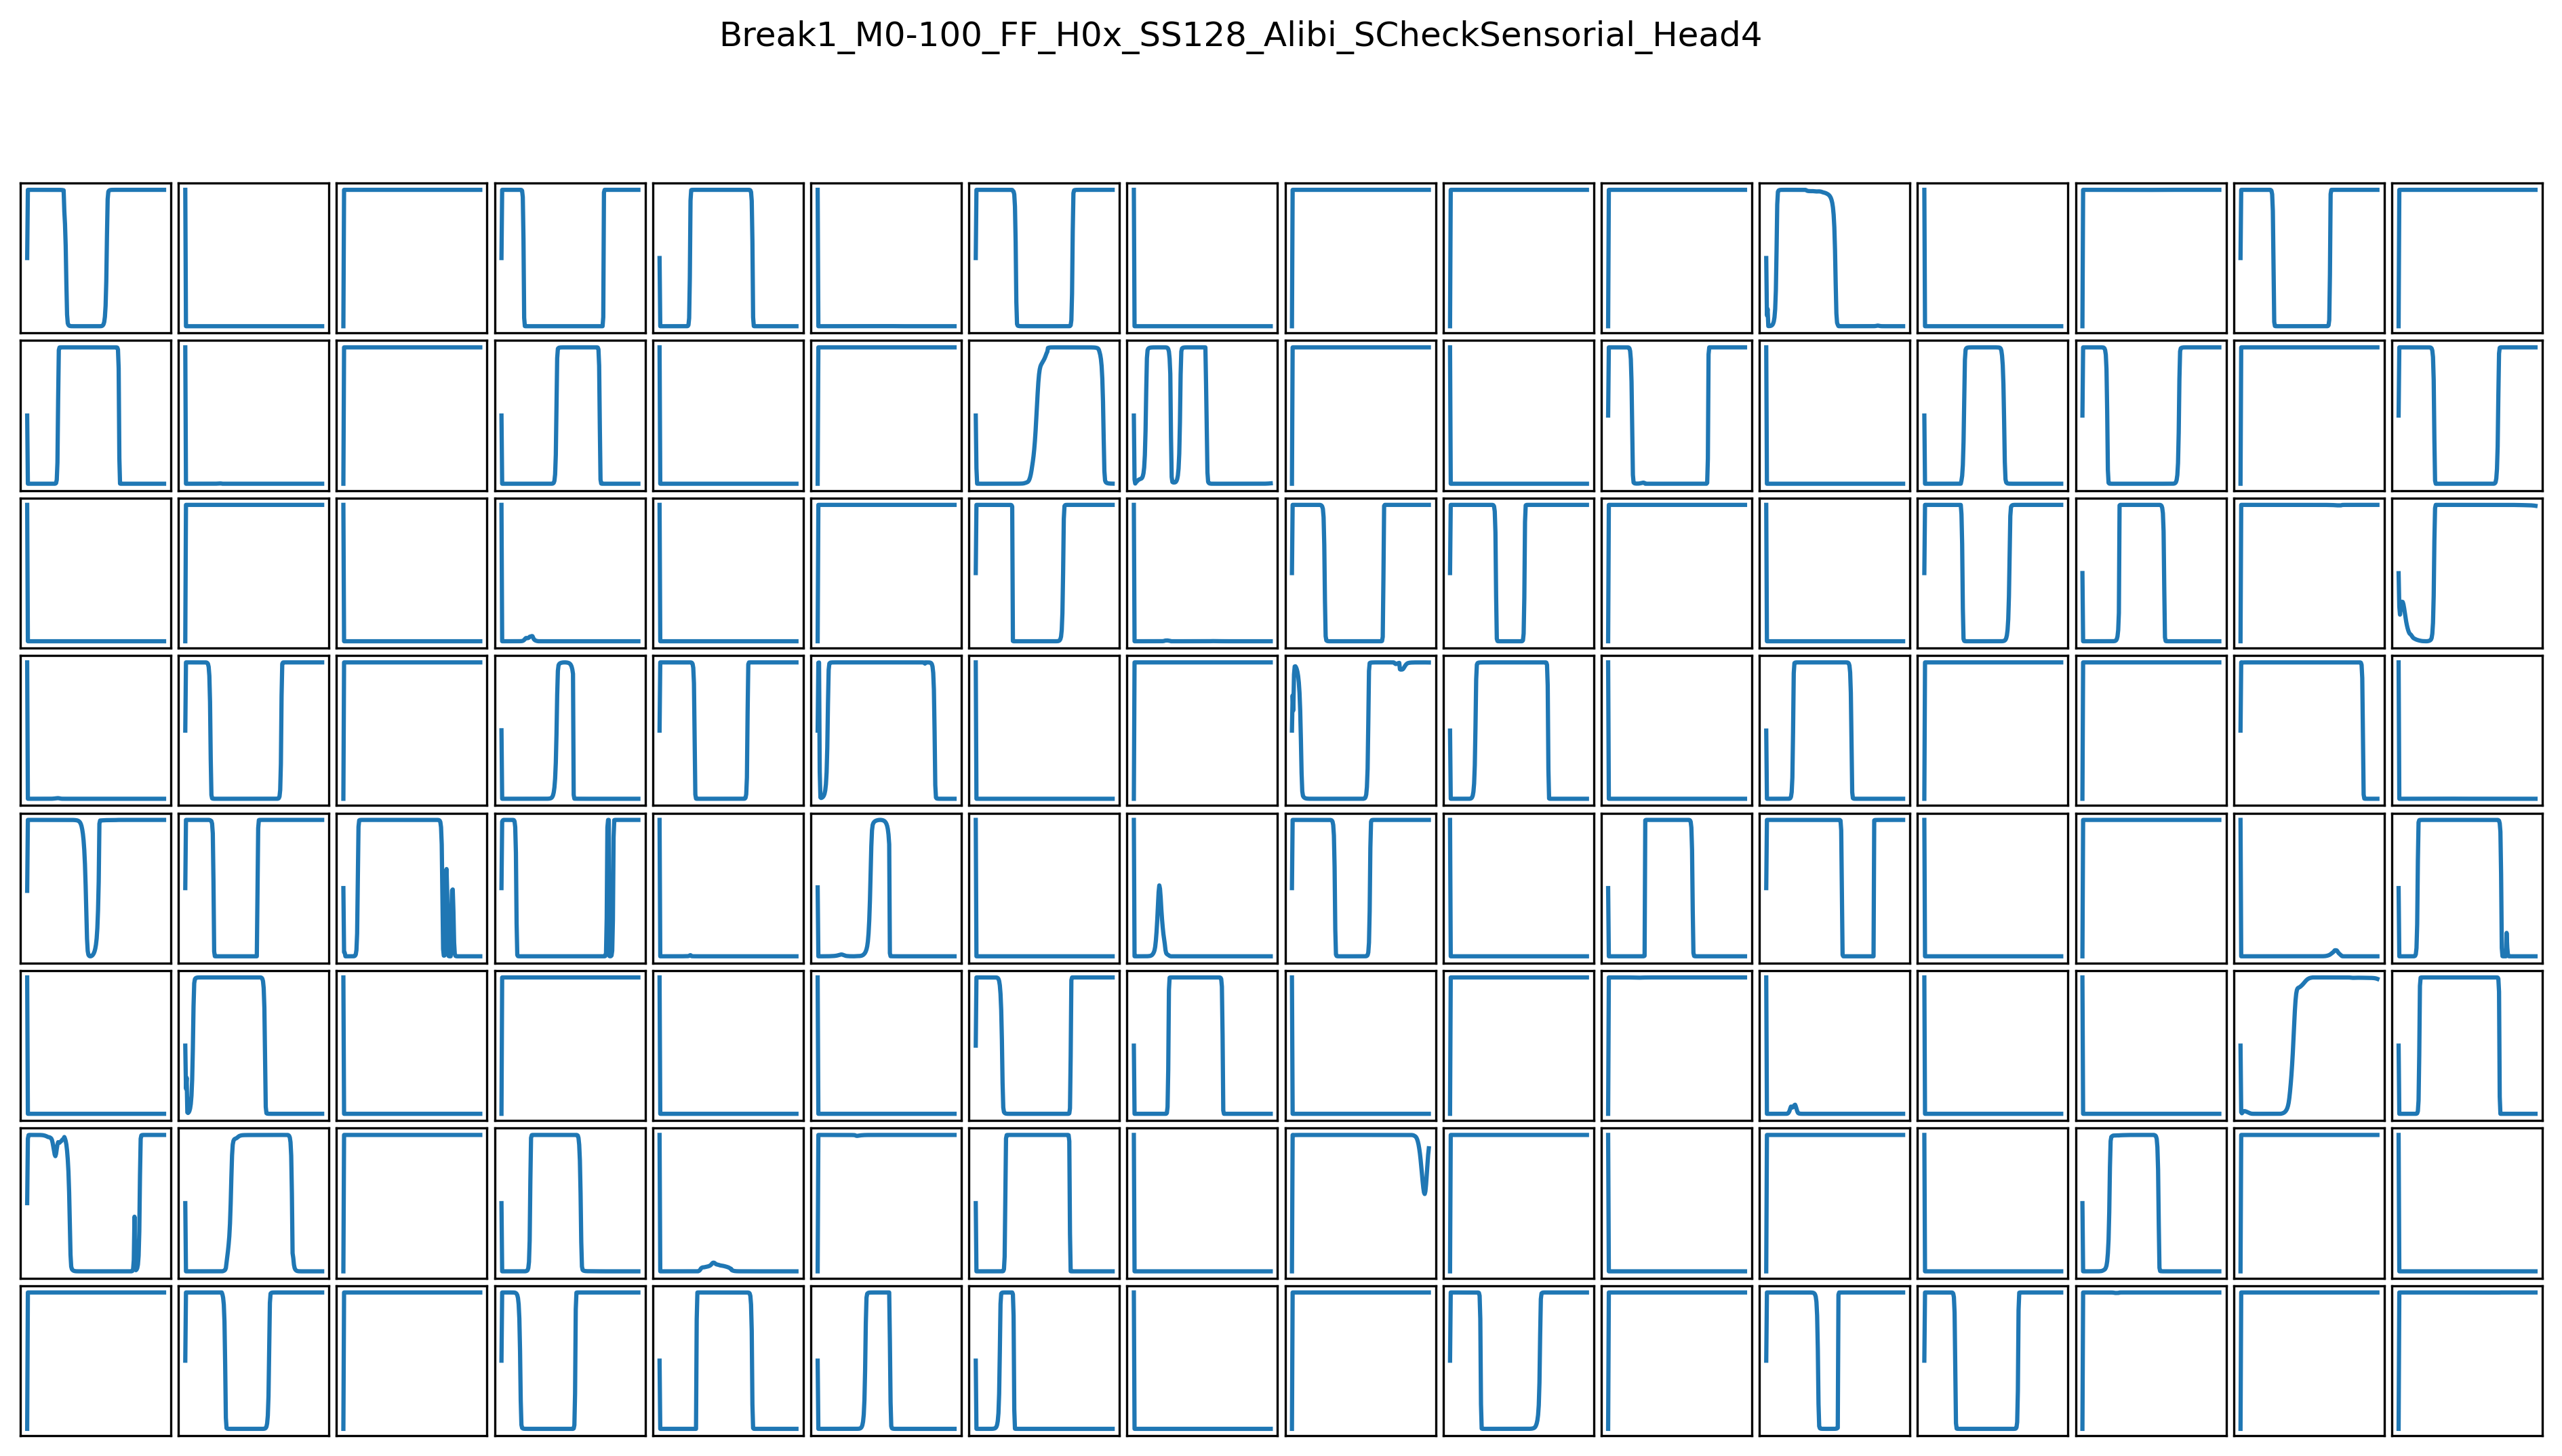

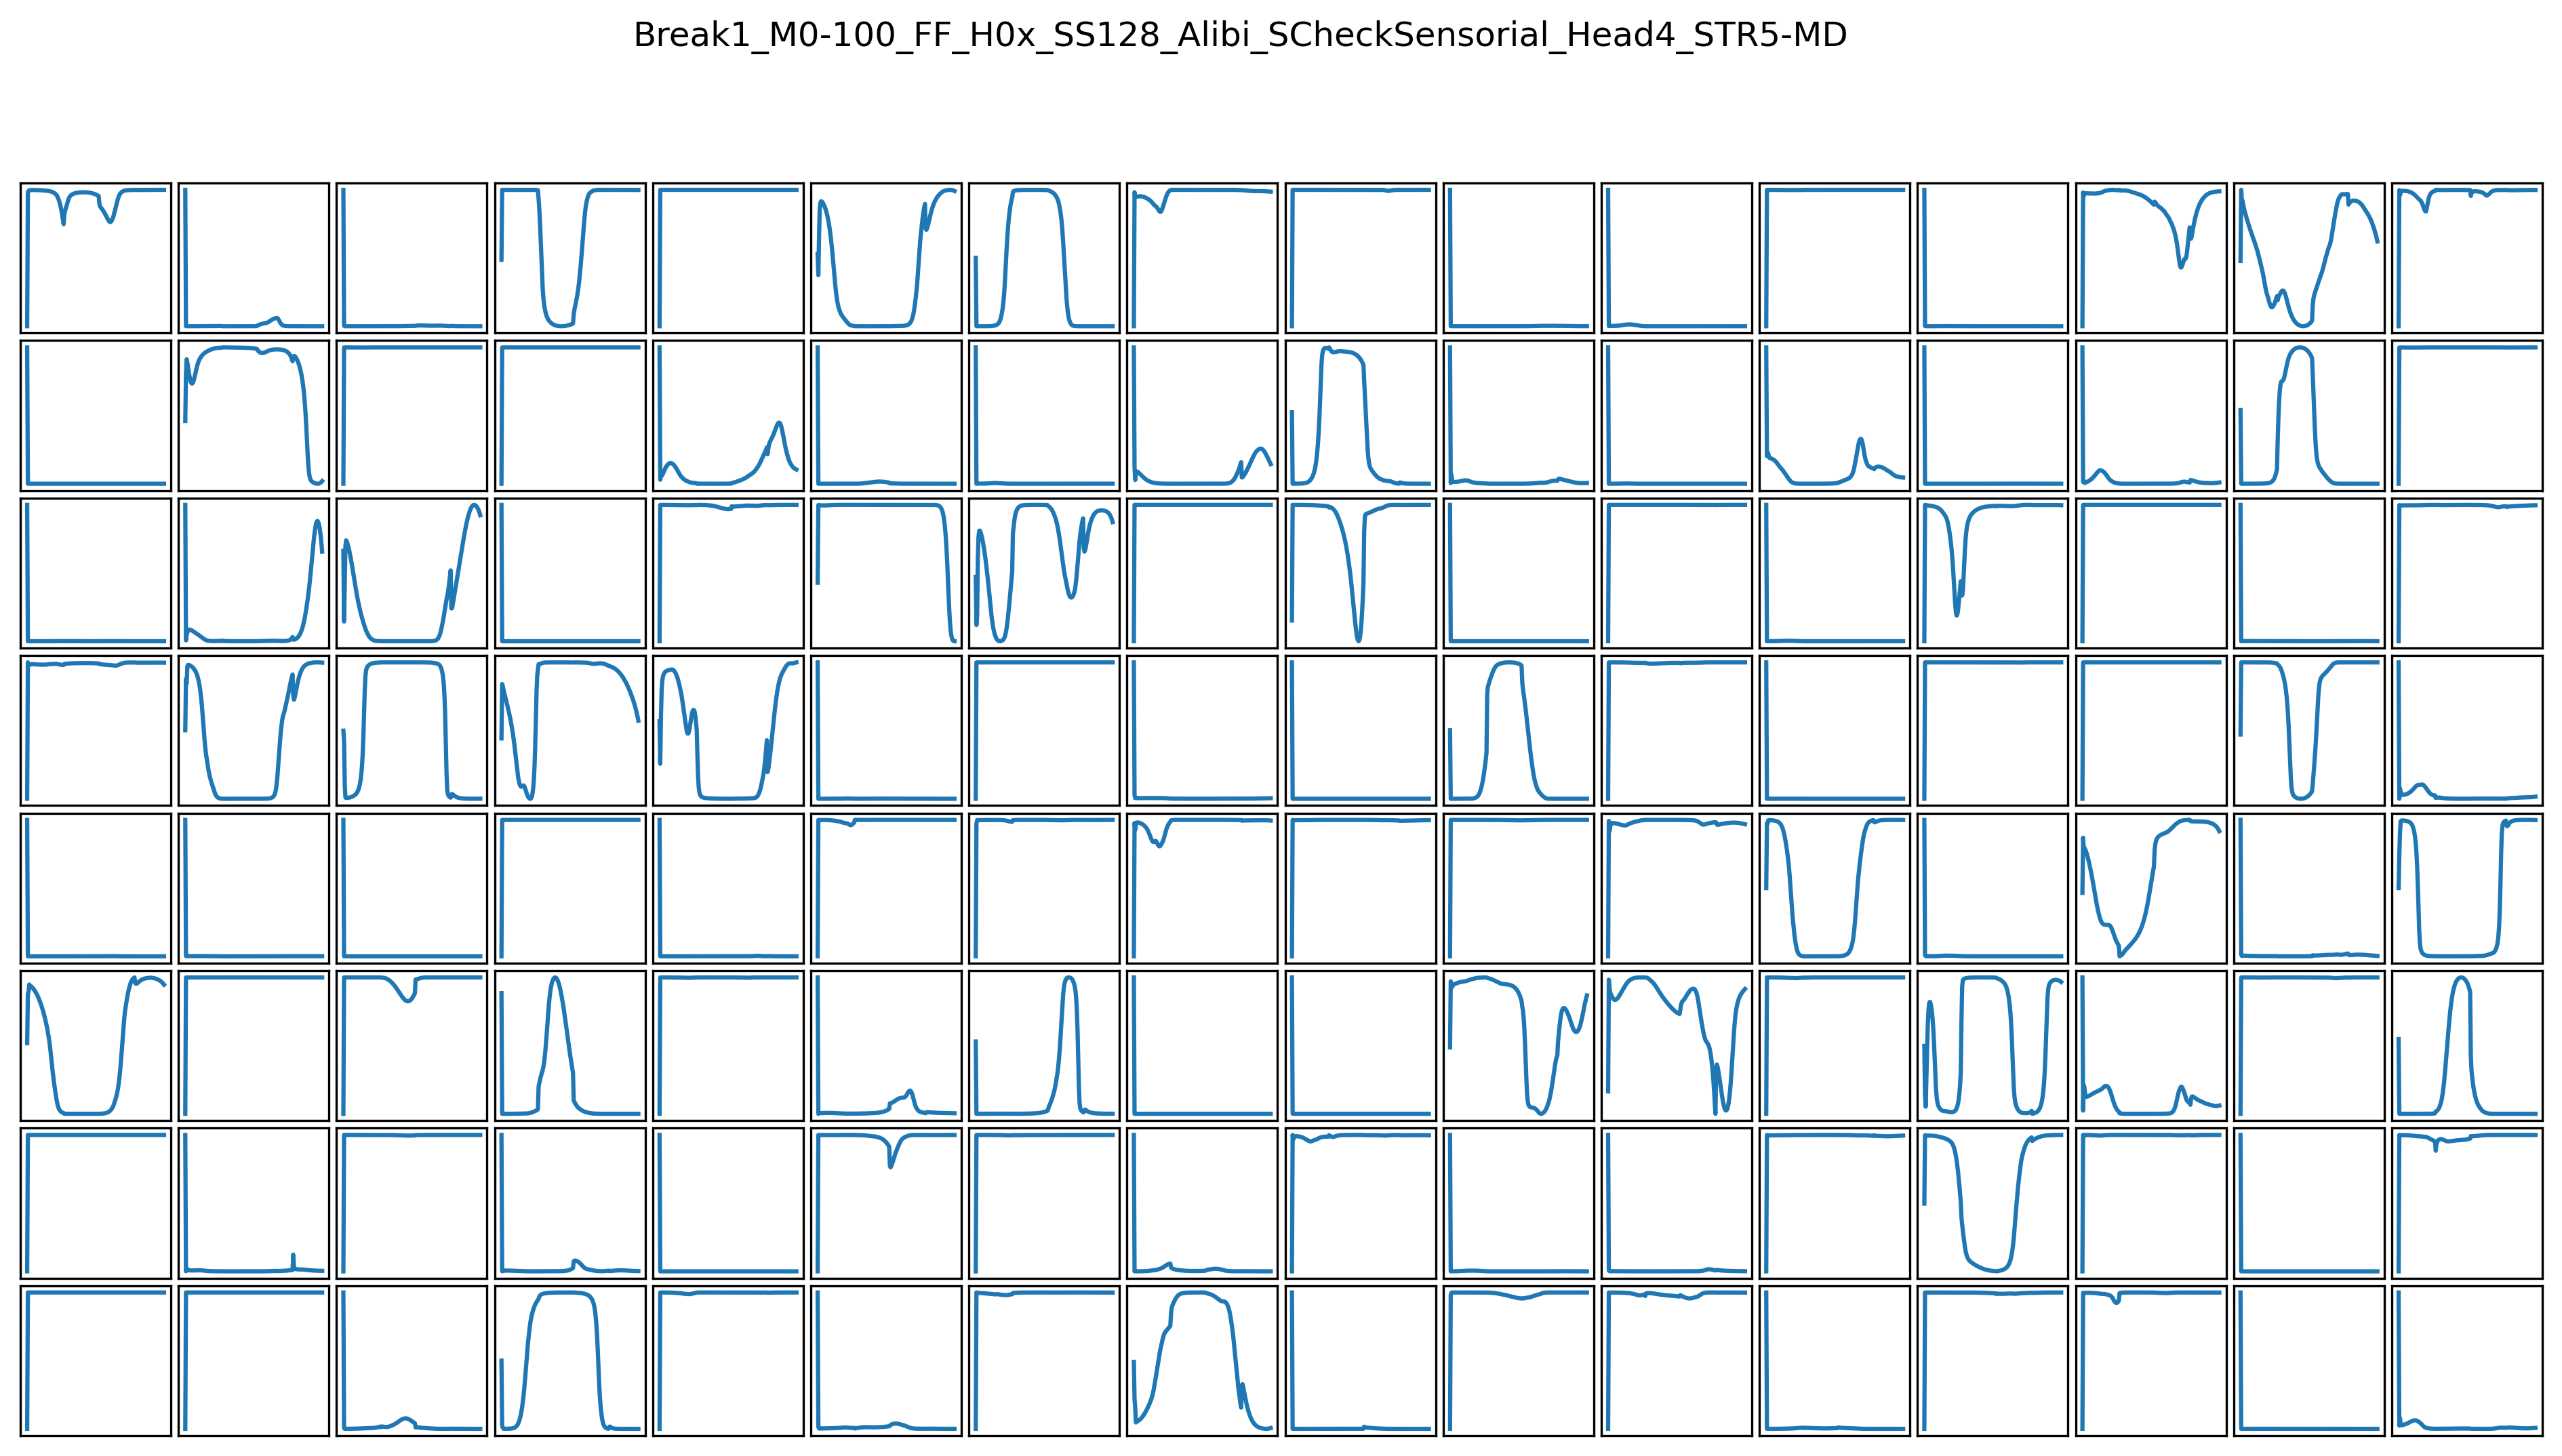

In [8]:
seq_to_plot = 0

for name in logits_full:
    axis = 0
    fig, axs = plt.subplots(8, 16, dpi=300, figsize=(16, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

    for i in range(128):
        row = i // 16
        column = i % 16

        axs[row, column].plot(state[name][seq_to_plot, :, i].cpu())

        axs[row, column].set_xticks([])
        axs[row, column].set_yticks([])

    #plt.legend(bbox_to_anchor=(2.5, 4.5), loc='upper right')
    
    plt.suptitle(name)

    plt.show()

In [9]:
names

['Break1_M0-100_FF_H0x_SS128_Alibi_SCheckSensorial_Head4',
 'Break1_M0-100_FF_H0x_SS128_Alibi_SCheckSensorial_Head4_STR5-MD']

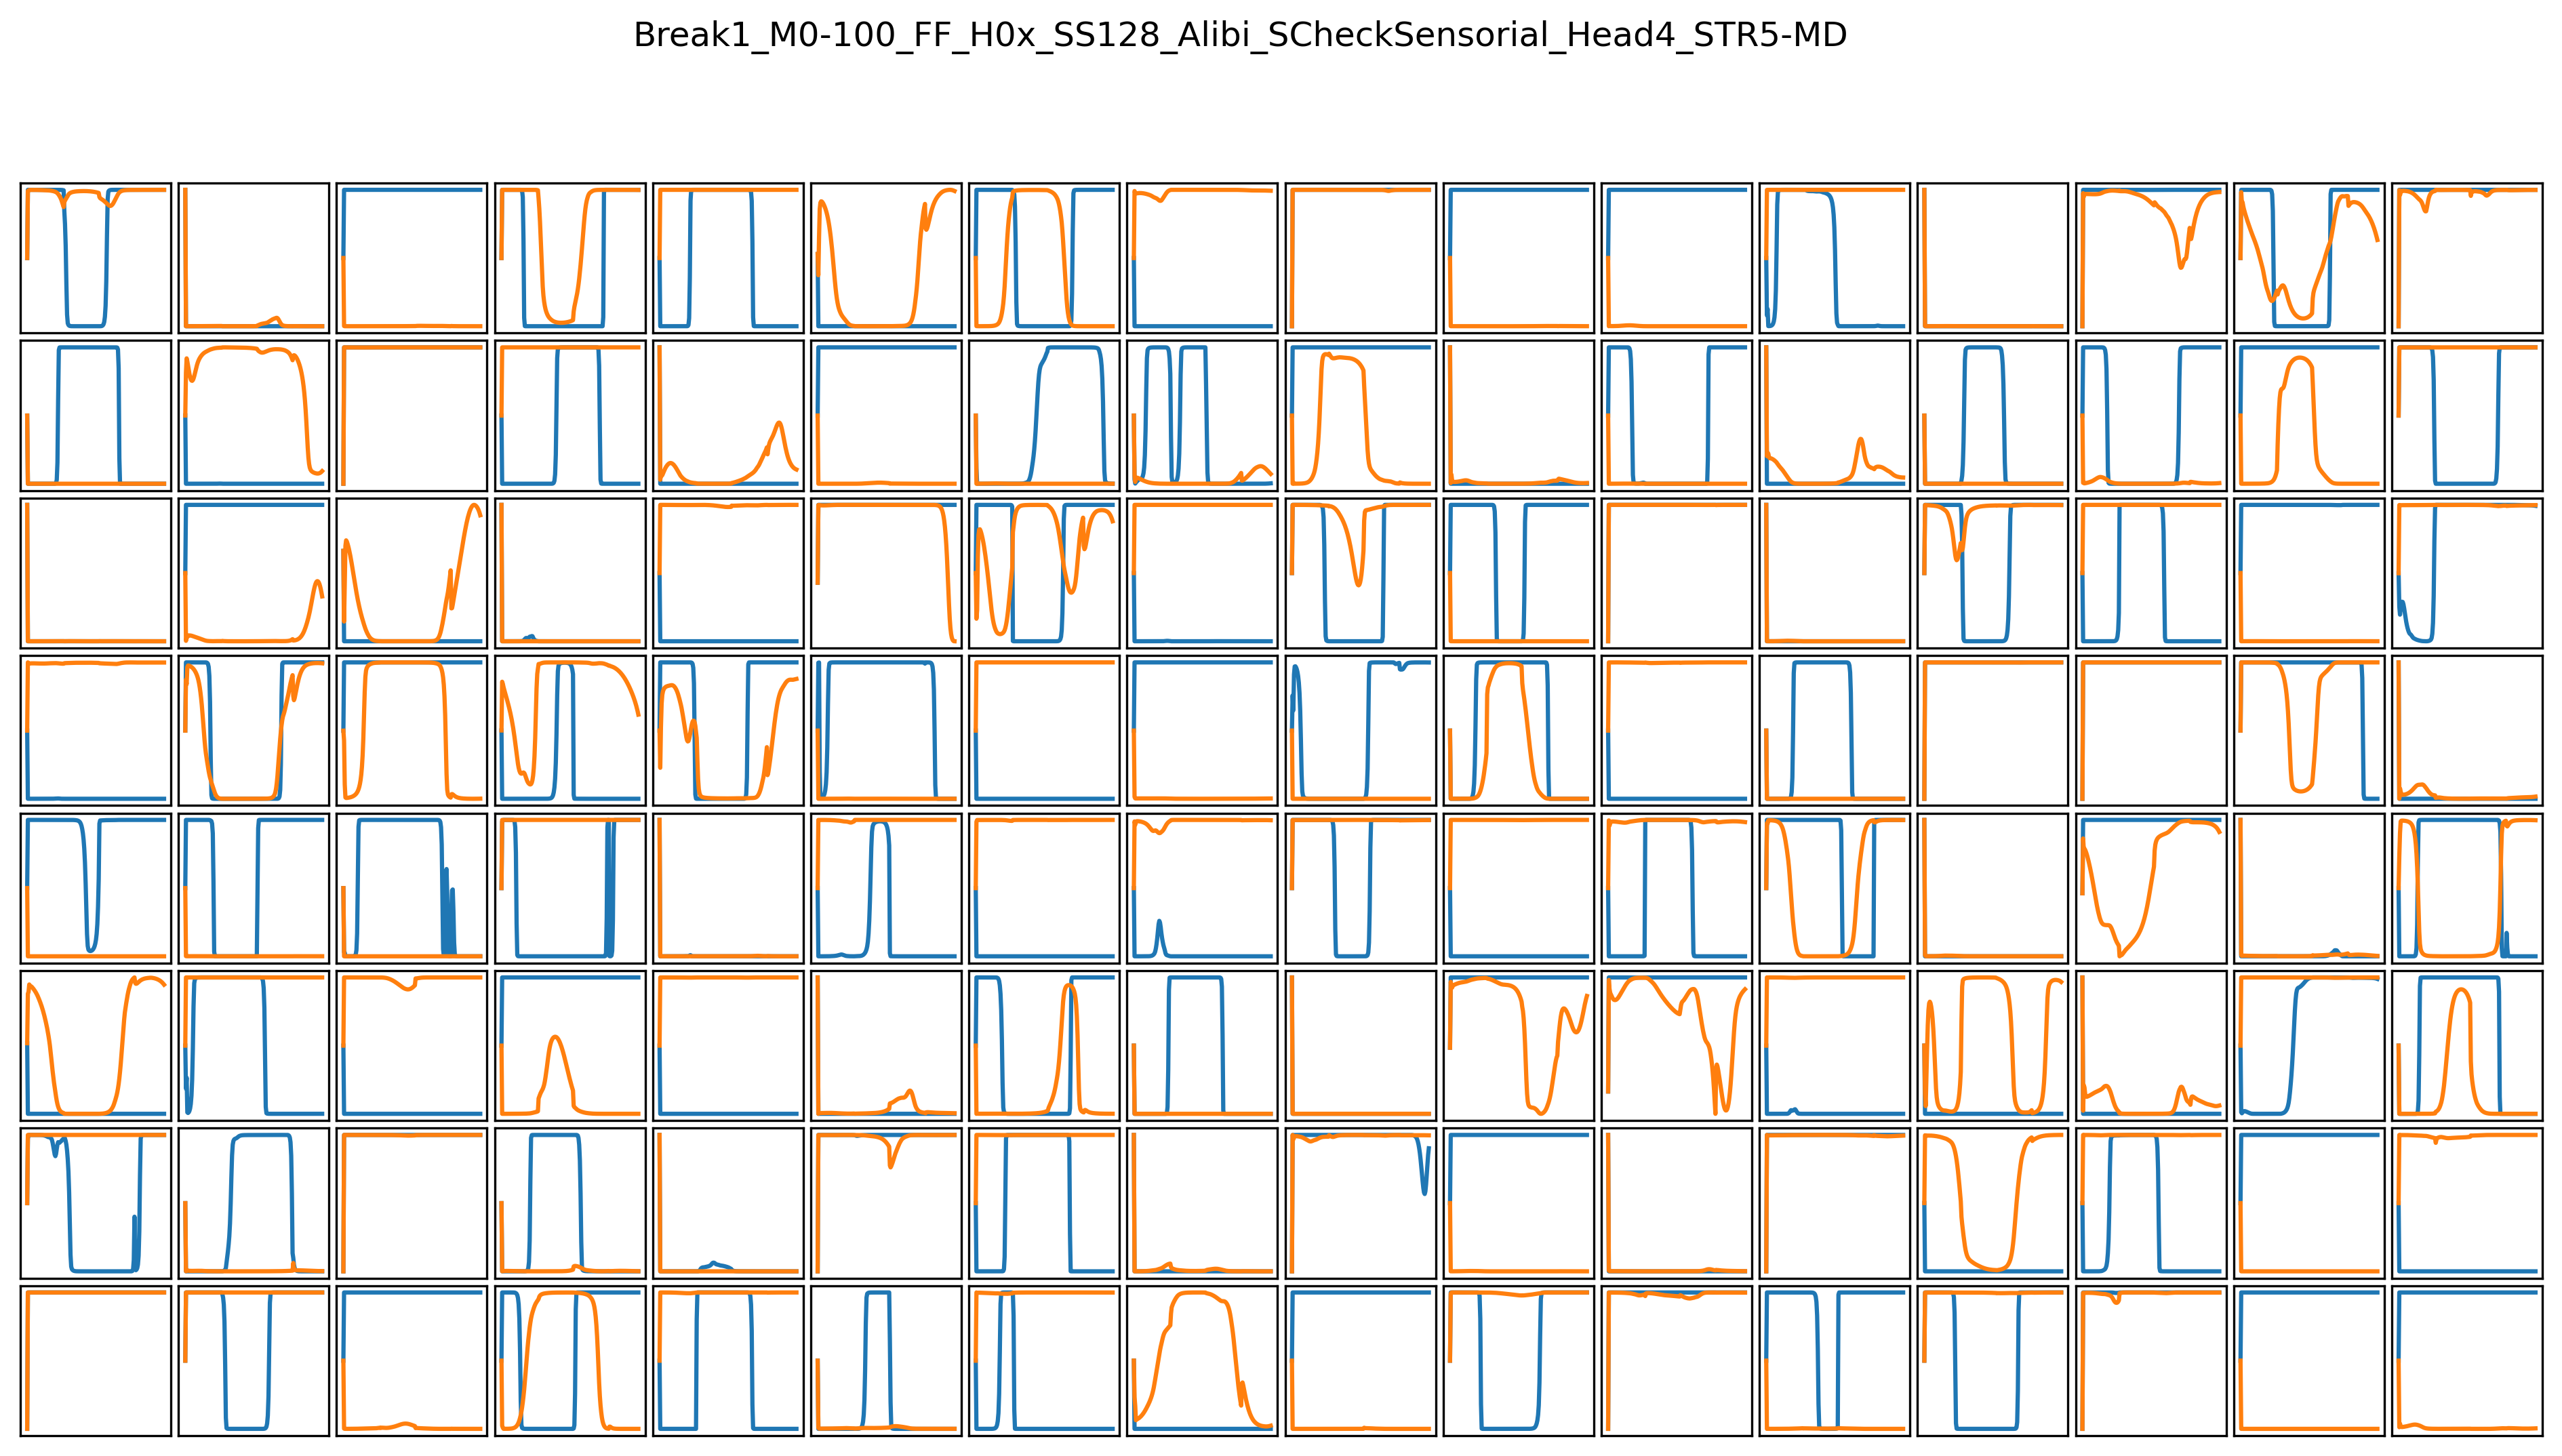

In [10]:
seq_to_plot = 0

axis = 0
fig, axs = plt.subplots(8, 16, dpi=300, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for i in range(128):
    row = i // 16
    column = i % 16
    
    for name in names:
        axs[row, column].plot(state[name][seq_to_plot, :, i].cpu(), label=name)

    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])

#plt.legend(bbox_to_anchor=(2.5, 4.5), loc='upper right')

plt.suptitle(name)

plt.show()

In [11]:
model_name = 'Break1_M0-100_FF_H0x_SS128_Alibi_SCheckSensorial_Head4_STR5-MD'

In [12]:
null_sensorial_data: TensorDict = inputs[:1, :1].clone()

null_sensorial_data_masks = TensorDict(device=device, batch_size=1)

for name in null_sensorial_data.keys():
    null_sensorial_data_masks[name] = torch.zeros(
        (1, 1), dtype=bool, device=device)

In [13]:
for param in models[model_name].parameters():
    param.requires_grad = False

In [14]:
mse_loss = torch.nn.MSELoss()

In [26]:
torch.set_grad_enabled(True)

optimal_state = state[model_name][0,:].clone()

hist = [[] for _ in range(200)]

patience = 3


for i in tqdm.tqdm(range(198, 190, -1)):
    next_state = (optimal_state[i+1].unsqueeze(0).unsqueeze(0))
    current_state = torch.nn.Parameter((2*torch.rand((1, 1, state_size)))-1)#torch.nn.Parameter(next_state)#

    optim = torch.optim.Adam([current_state]) #NOSONAR

    n = 0
    prev_loss = 10000
    stale = 0
    while prev_loss>0.1 and n < 3000 :
        logits = models[model_name](state=current_state,  sensorial_data=null_sensorial_data, sensorial_masks=null_sensorial_data_masks, input_sequence_size=1)

        loss = mse_loss(logits["state"], next_state)

        hist[i].append(loss.detach().cpu().item())

        loss.backward()

        optim.step()
        
        loss = loss.detach().cpu().item()

        n += 1

        if prev_loss < loss:
            stale += 1
        else:
            stale = 0

        if stale >= patience:
            break

        prev_loss = loss

    print(n, loss)
    optimal_state[i] = current_state[0,0,:].detach()

 12%|█▎        | 1/8 [00:33<03:53, 33.40s/it]

993 0.15426227450370789


 25%|██▌       | 2/8 [01:53<06:04, 60.73s/it]

3000 1.286539077758789


 25%|██▌       | 2/8 [02:12<06:37, 66.26s/it]


KeyboardInterrupt: 

In [27]:
torch.set_grad_enabled(False)

In [29]:
optimal_state.shape

torch.Size([200, 128])

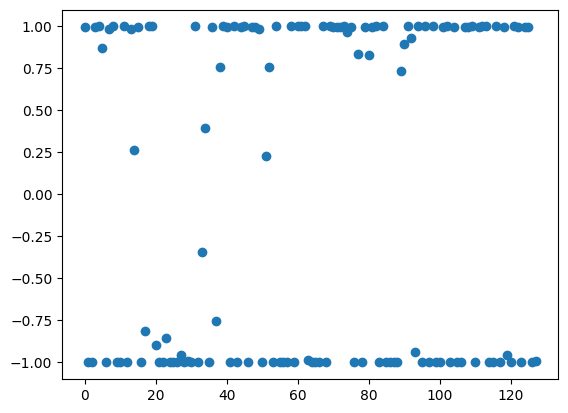

In [ ]:
plt.plot(optimal_state[-1,:].cpu(), "o")
plt.plot(state[-1,:].cpu(), "o")
plt.show()
plt.plot(optimal_state[-1,:].cpu(), "o")

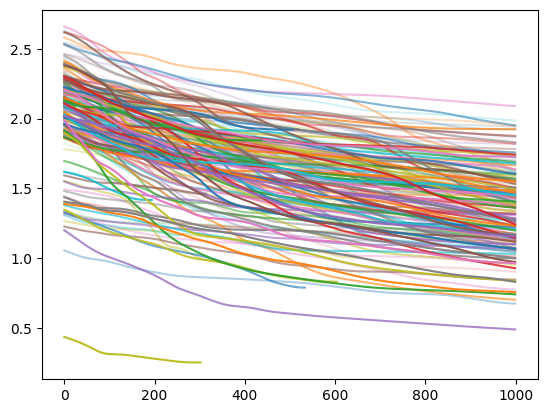

In [ ]:
for i in range(200):
    plt.plot(hist[i], alpha=(i/200))

In [ ]:
logits

TensorDict(
    fields={
        measurement: Tensor(shape=torch.Size([1, 1, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
        state: Tensor(shape=torch.Size([1, 1, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        state_control: Tensor(shape=torch.Size([1, 1, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        state_decoded: Tensor(shape=torch.Size([1, 1, 3]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1, 1]),
    device=cuda:0,
    is_shared=True)

In [ ]:
test_state = optimal_state.clone()

In [ ]:
null_sensorial_data: TensorDict = inputs[:1].clone()

null_sensorial_data_masks = TensorDict(device=device, batch_size=[1,200])

for name in null_sensorial_data.keys():
    null_sensorial_data_masks[name] = torch.zeros(
        (1, 200), dtype=bool, device=device)

In [ ]:
logits = models[model_name](state=test_state.unsqueeze(0),  sensorial_data=null_sensorial_data, sensorial_masks=null_sensorial_data_masks, input_sequence_size=200)

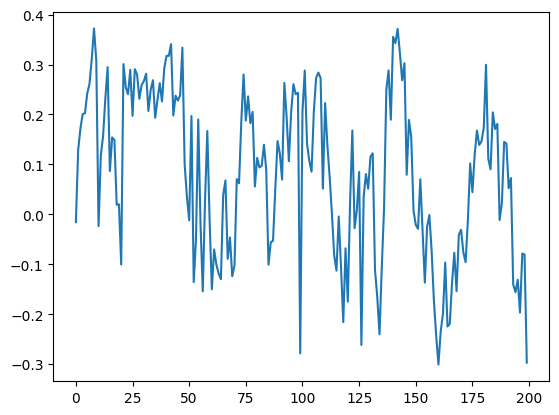

In [ ]:
plt.plot(logits["state_decoded"].detach().cpu()[0,:,0])
plt.plot(logits["state_decoded"].detach().cpu()[0,:,0])

In [ ]:
import pickle

In [ ]:
backup = {
    "hist":hist,
    "optimal_state":optimal_state.detach().cpu().numpy()
}

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
test_state

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
